In [ ]:
!pip install pydicom
!pip install torch
!pip install torchio


!git clone https://github.com/Tencent/MedicalNet.git
!wget https://huggingface.co/TencentMedicalNet/MedicalNet-Resnet18/resolve/main/resnet_18_23dataset.pth -O medicalnet_resnet18.pth





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 19.7 MB/s eta 0:00:00m eta 0:00:01
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.0/865.0 MB 35.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 31.0 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 31.5 MB/s eta 0:00:0031m33.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.7 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 31.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 28.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!mv /content/MedicalNet/* /content/
!mv /content/MedicalNet/.* /content/ 2>/dev/null  # hidden files

import sys
sys.path.append('/content/model.py')


In [ ]:
!mv /content/MedicalNet/* /content/
!mv /content/MedicalNet/.* /content/ 2>/dev/null  # hidden files

import sys
sys.path.append('/content/model.py')


In [ ]:

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import torch
import torch.nn as nn

import pydicom as dicom
import matplotlib.patches as patches

from matplotlib import animation, rc
import pandas as pd

import pydicom as dicom # dicom
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_data.csv")
train_data = train_data[['study_id', 'condition', 'level', 'series_id', 'instance_number']]
print(train_data)

         study_id                    condition  level   series_id  \
0         4003253        Spinal Canal Stenosis  L1/L2   702807833   
1         4003253        Spinal Canal Stenosis  L2/L3   702807833   
2         4003253        Spinal Canal Stenosis  L3/L4   702807833   
3         4003253        Spinal Canal Stenosis  L4/L5   702807833   
4         4003253        Spinal Canal Stenosis  L5/S1   702807833   
...           ...                          ...    ...         ...   
48652  4290709089  Right Subarticular Stenosis  L1/L2  3390218084   
48653  4290709089  Right Subarticular Stenosis  L2/L3  3390218084   
48654  4290709089  Right Subarticular Stenosis  L3/L4  3390218084   
48655  4290709089  Right Subarticular Stenosis  L4/L5  3390218084   
48656  4290709089  Right Subarticular Stenosis  L5/S1  3390218084   

       instance_number  
0                    8  
1                    8  
2                    8  
3                    8  
4                    8  
...                ..

In [ ]:
# Step 1: Count number of distinct series_ids per study_id
series_count = train_data.groupby('study_id')['series_id'].nunique()

# Step 2: Get study_ids with exactly 3 distinct series_ids
valid_studies = series_count[series_count == 3].index

# Step 3: Filter the original DataFrame to keep only those study_ids
df_cleaned = train_data[train_data['study_id'].isin(valid_studies)]


distinct_study_count = df_cleaned['study_id'].nunique()
print(f"Total distinct study_ids: {distinct_study_count}")
print(f"Filtered entries: {len(df_cleaned)}")

Total distinct study_ids: 1634
Filtered entries: 40233


In [ ]:
import pandas as pd


# Function to process datasets
def process_condition(df_condition, is_spinal_canal=False):
    df_condition = df_condition.copy()
    pivot_columns = []

    if is_spinal_canal:
        # For Spinal Canal Stenosis (single side)
        for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
            pivot_columns.append(f'level_{level}_Instance_number')
    else:
        # For Left and Right versions (double sides)
        for side in ['Left', 'Right']:
            for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
                pivot_columns.append(f'{side}_level_{level}_Instance_number')

    # Create a new column to distinguish Left/Right for double sided conditions
    if not is_spinal_canal:
        df_condition['side'] = df_condition['condition'].apply(lambda x: 'Left' if 'Left' in x else 'Right')

    # Pivot logic
    if is_spinal_canal:
        pivot_df = df_condition.pivot(index=['study_id', 'series_id'], columns='level', values='instance_number')
        pivot_df = pivot_df.rename(columns={
            'L1/L2': 'level_L1/L2_Instance_number',
            'L2/L3': 'level_L2/L3_Instance_number',
            'L3/L4': 'level_L3/L4_Instance_number',
            'L4/L5': 'level_L4/L5_Instance_number',
            'L5/S1': 'level_L5/S1_Instance_number'
        })
    else:
        # For Left and Right combined
        pivot_df = df_condition.pivot_table(index=['study_id', 'series_id'],
                                            columns=['side', 'level'],
                                            values='instance_number')
        # Flatten columns
        pivot_df.columns = [f'{side}_level_{lvl}_Instance_number' for side, lvl in pivot_df.columns]

    # Reset index for clean DataFrame
    pivot_df = pivot_df.reset_index()

    return pivot_df

# Step 3: Create different condition DataFrames

# (1) Spinal Canal Stenosis
df_spinal_canal = df_cleaned[df_cleaned['condition'] == 'Spinal Canal Stenosis']
df_spinal_canal_processed = process_condition(df_spinal_canal, is_spinal_canal=True)

# (2) Neural Foraminal Narrowing (Left + Right combined)
df_neural_foraminal = df_cleaned[df_cleaned['condition'].str.contains('Neural Foraminal Narrowing')]
df_neural_foraminal_processed = process_condition(df_neural_foraminal, is_spinal_canal=False)

# (3) Subarticular Stenosis (Left + Right combined)
df_subarticular_stenosis = df_cleaned[df_cleaned['condition'].str.contains('Subarticular Stenosis')]
df_subarticular_stenosis_processed = process_condition(df_subarticular_stenosis, is_spinal_canal=False)

# Final Output
print("Spinal Canal Stenosis Processed:")
print(df_spinal_canal_processed.head())

print("\nNeural Foraminal Narrowing Processed:")
print(df_neural_foraminal_processed.head())

print("\nSubarticular Stenosis Processed:")
print(df_subarticular_stenosis_processed.head())


Spinal Canal Stenosis Processed:
level  study_id   series_id  level_L1/L2_Instance_number  \
0       4003253   702807833                            8   
1       4646740  3666319702                           10   
2       7143189   132939515                            9   
3       8785691   481125819                            8   
4      11340341  3543553307                           10   

level  level_L2/L3_Instance_number  level_L3/L4_Instance_number  \
0                                8                            8   
1                               10                            9   
2                                9                            9   
3                                8                            8   
4                               10                           10   

level  level_L4/L5_Instance_number  level_L5/S1_Instance_number  
0                                8                            8  
1                               10                           11  
2    

In [ ]:
print("Spinal Canal Stenosis Processed:")
print(len(df_spinal_canal_processed))

print("\nNeural Foraminal Narrowing Processed:")
print(len(df_neural_foraminal_processed))

print("\nSubarticular Stenosis Processed:")
print(len(df_subarticular_stenosis_processed))

Spinal Canal Stenosis Processed:
1465

Neural Foraminal Narrowing Processed:
1465

Subarticular Stenosis Processed:
1465


In [ ]:
existing_study_ids = []  # or pre-populate with some values

# Step 1: Find rows with at least one NaN
rows_with_nan = df_spinal_canal_processed[df_spinal_canal_processed.isna().any(axis=1)]
#rows_with_nan = df_neural_foraminal_processed[df_neural_foraminal_processed.isna().any(axis=1)]
#rows_with_nan = df_subarticular_stenosis_processed[df_subarticular_stenosis_processed.isna().any(axis=1)]

# Step 2: Extract unique study_ids from those rows
nan_study_ids = rows_with_nan['study_id'].unique()

# Step 3: Append only new study_ids to the existing list
for study_id in nan_study_ids:
    if study_id not in existing_study_ids:
        existing_study_ids.append(study_id)

df_spinal_canal_processed = df_spinal_canal_processed[~df_spinal_canal_processed['study_id'].isin(existing_study_ids)]
#df_neural_foraminal_processed = df_neural_foraminal_processed[~df_neural_foraminal_processed['study_id'].isin(existing_study_ids)]
#df_subarticular_stenosis_processed = df_subarticular_stenosis_processed[~df_subarticular_stenosis_processed['study_id'].isin(existing_study_ids)]

In [ ]:
df_spinal_canal_processed.to_csv('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/spinal_canal_processed.csv', index=False)
df_neural_foraminal_processed.to_csv('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/neural_foraminal_processed.csv', index=False)
df_subarticular_stenosis_processed.to_csv('/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/subarticular_stenosis_processed.csv', index=False)

print("✅ All files saved successfully.")

✅ All files saved successfully.


In [ ]:
df_spinal_canal_processed=pd.read_csv("/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/spinal_canal_processed.csv")
df_neural_foraminal_processed=pd.read_csv("/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/neural_foraminal_processed.csv")
df_subarticular_stenosis_processed=pd.read_csv("/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/subarticular_stenosis_processed.csv")
print(df_spinal_canal_processed, df_neural_foraminal_processed, df_subarticular_stenosis_processed)

        study_id   series_id  level_L1/L2_Instance_number  \
0        4003253   702807833                            8   
1        4646740  3666319702                           10   
2        7143189   132939515                            9   
3        8785691   481125819                            8   
4       11340341  3543553307                           10   
...          ...         ...                          ...   
1460  4282019580  1547999333                           11   
1461  4283570761   453728183                            9   
1462  4284048608  3767301072                           10   
1463  4287160193  1507070277                            8   
1464  4290709089  3274612423                            9   

      level_L2/L3_Instance_number  level_L3/L4_Instance_number  \
0                               8                            8   
1                              10                            9   
2                               9                            9   
3  

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import pydicom
import torchio as tio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


def get_3d_transform_pipeline(is_train=True):
    transforms = [
        tio.Resample((1.5, 1.5, 3.0)),             # Spatial normalization to median voxel spacing
        tio.CropOrPad((16, 112, 112)),             # Fixed input size
        tio.ZNormalization(),                      # Intensity normalization (mean 0, std 1)
        tio.Clamp(out_min=-5, out_max=5),          # Truncate outliers
    ]

    if is_train:
        transforms += [
            tio.RandomAffine(scales=(0.9, 1.1), degrees=10, translation=5, p=0.5),
            tio.RandomNoise(p=0.3),
            tio.RandomBiasField(p=0.25),
        ]

    return tio.Compose(transforms)

class SpinalVolumeDataset(Dataset):
    def __init__(self, dataframe, base_dir, label_cols, is_train=True):
        """
        :param dataframe: DataFrame with study_id, series_id, and instance number labels
        :param base_dir: Base folder path containing /study_id/series_id/*.dcm structure
        :param label_cols: List of column names for target labels (5 or 10)
        :param is_train: Whether to apply TorchIO 3D augmentations
        """
        self.df = dataframe
        self.base_dir = base_dir
        self.label_cols = label_cols
        self.is_train = is_train

        # Define 3D augmentation pipeline
        self.transform = get_3d_transform_pipeline(is_train)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_id = str(int(float(self.df['study_id'][idx])))
        series_id = str(int(float(self.df['series_id'][idx])))


        volume_path = os.path.join(self.base_dir, study_id, series_id)

        # Load sorted volume
        volume = self.load_dicom_volume_sorted(volume_path)  # shape: (D, H, W)
        depth = volume.shape[0]

        volume = np.expand_dims(volume, axis=0)  # shape: (1, D, H, W)

        # Apply TorchIO transforms
        subject = tio.Subject(img=tio.ScalarImage(tensor=volume))
        transformed = self.transform(subject)
        volume = transformed.img.data  # (1, D, H, W)

        # Normalize labels
        target = torch.tensor([row[col] for col in self.label_cols], dtype=torch.float32)
        target = target / depth

        return volume, target

    def load_dicom_volume_sorted(self, folder_path):
        # Read DICOM files sorted by InstanceNumber
        slice_list = []
        for fname in os.listdir(folder_path):
            if fname.endswith('.dcm'):
                full_path = os.path.join(folder_path, fname)
                dcm = pydicom.dcmread(full_path)
                instance_number = getattr(dcm, 'InstanceNumber', 0)
                slice_list.append((instance_number, dcm))

        slice_list.sort(key=lambda x: x[0])

        volume = []
        for _, dcm in slice_list:
            img = dcm.pixel_array.astype(np.float32)
            img = cv2.resize(img, (112, 112))
            img = img / np.max(img) if np.max(img) > 0 else img
            volume.append(img)

        volume = np.stack(volume, axis=0)  # shape: (D, H, W)
        return volume



def create_datasets_and_loaders(df, cond, batch_size=16):

    # Create train/validation split
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)


    # Create dataset objects
    if cond =='scs':
       label_cols = ['level_L1/L2_Instance_number',
                     'level_L2/L3_Instance_number',
                     'level_L3/L4_Instance_number',
                     'level_L4/L5_Instance_number',
                     'level_L5/S1_Instance_number',]

    else:
      label_cols = ['Left_level_L1/L2_Instance_number',
                    'Left_level_L2/L3_Instance_number',
                    'Left_level_L3/L4_Instance_number',
                    'Left_level_L4/L5_Instance_number',
                    'Left_level_L5/S1_Instance_number',
                    'Right_level_L1/L2_Instance_number',
                    'Right_level_L2/L3_Instance_number',
                    'Right_level_L3/L4_Instance_number',
                    'Right_level_L4/L5_Instance_number',
                    'Right_level_L5/S1_Instance_number',]

    train_dataset = SpinalVolumeDataset(
    dataframe=train_df,
    base_dir='/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_images',
    label_cols=label_cols,
    is_train=True
)

    val_dataset  = SpinalVolumeDataset(
    dataframe=val_df,
    base_dir='/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/train_images',
    label_cols=label_cols,
    is_train=False
)

    # Create dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    print("Train size:", len(train_df))
    print("Val size:", len(val_df))
    print("Len trainloader:", len(trainloader))          # number of batches
    print("Samples per batch:", trainloader.batch_size)  # should be 32
    print("Total samples:", len(trainloader.dataset))    # should be close to 1172



    return trainloader, valloader, len(train_df), len(val_df)

dataloaders = {}
lengths = {}

trainloader_t1, valloader_t1, len_train_t1, len_val_t1 = create_datasets_and_loaders(df=df_neural_foraminal_processed, cond='nfn')
trainloader_t2, valloader_t2, len_train_t2, len_val_t2 = create_datasets_and_loaders(df=df_subarticular_stenosis_processed, cond='ss')
trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir = create_datasets_and_loaders(df=df_spinal_canal_processed, cond='scs')

dataloaders['Sagittal T1'] = (trainloader_t1, valloader_t1)
dataloaders['Axial T2'] = (trainloader_t2, valloader_t2)
dataloaders['Sagittal T2/STIR'] = (trainloader_t2stir, valloader_t2stir)

lengths['Sagittal T1'] = (len_train_t1, len_val_t1)
lengths['Axial T2'] = (len_train_t2, len_val_t2)
lengths['Sagittal T2/STIR'] = (len_train_t2stir, len_val_t2stir)

Train size: 1172
Val size: 293
Len trainloader: 74
Samples per batch: 16
Total samples: 1172
Train size: 1172
Val size: 293
Len trainloader: 74
Samples per batch: 16
Total samples: 1172
Train size: 1172
Val size: 293
Len trainloader: 74
Samples per batch: 16
Total samples: 1172


In [ ]:
import os
import torch
import torch.nn as nn
from model import generate_model


# Define the config-style class used by MedicalNet's generate_model()
class MedicalNetOptions:
    def __init__(self, model_depth=18, input_D=16, input_H=112, input_W=122):
        self.model = 'resnet'
        self.model_depth = model_depth
        self.input_D = input_D
        self.input_H = input_H
        self.input_W = input_W
        self.resnet_shortcut = 'A'
        self.no_cuda = False
        self.n_seg_classes = 1
        self.gpu_id = [0]
        self.phase = 'train'
        self.pretrain_path = ''
        self.new_layer_names = []

# Main wrapper class to use MedicalNet's ResNet18
class MedicalNet3DResNet18(nn.Module):
    def __init__(self, output_dim=10, pretrained_path=None, freeze_until=2):
        """
        :param output_dim: Number of regression outputs (5 or 10)
        :param pretrained_path: Path to downloaded MedicalNet .pth weights
        :param freeze_until: Freeze N blocks (0 = none, 4 = all)
        """
        super(MedicalNet3DResNet18, self).__init__()

        # Create MedicalNet-style options object
        opt = MedicalNetOptions()

        # Generate base model
        self.backbone, *_ = generate_model(opt)
        def forward_patch(self_inner, x):
            x = self_inner.conv1(x)
            x = self_inner.bn1(x)
            x = self_inner.relu(x)
            x = self_inner.maxpool(x)
            x = self_inner.layer1(x)
            x = self_inner.layer2(x)
            x = self_inner.layer3(x)
            x = self_inner.layer4(x)
            return x

        self.backbone.module.forward = forward_patch.__get__(self.backbone.module, type(self.backbone.module))



        # Load pretrained weights if path is given
        if pretrained_path and os.path.exists(pretrained_path):
            checkpoint = torch.load(pretrained_path, map_location='cpu')
            state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
            new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
            self.backbone.load_state_dict(new_state_dict, strict=False)
        else:
            print("⚠️ No pretrained weights loaded. Using random initialization.")

        # Freeze early blocks
        self._freeze_layers(freeze_until)

        self.output_head = nn.Sequential(
             nn.AdaptiveAvgPool3d(1),  # Global average pooling
             nn.Flatten(),
             nn.Linear(512, output_dim),  # 512 is final channel count in ResNet18
             nn.Sigmoid()
         )

    def forward(self, x):
        x = self.backbone(x)  # Output: (B, 512, 1, 1, 1) or similar
        x = self.output_head(x)
        return x

    def _freeze_layers(self, freeze_until):
        """
        Freeze early blocks of ResNet18. freeze_until=2 freezes conv1 + layer1
        """
        freeze_blocks = ['conv1', 'layer1', 'layer2', 'layer3']
        for i, name in enumerate(freeze_blocks):
            if i < freeze_until:
                layer = getattr(self.backbone.module, name)
                for param in layer.parameters():
                    param.requires_grad = False



# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Path to pretrained weights
pretrained_path = '/content/medicalnet_resnet18.pth'  # already downloaded

# ====== Create model instances ======

# Neural Foraminal Narrowing (Sagittal T1): 10 labels
model_sagittal_t1 = MedicalNet3DResNet18(
    output_dim=10,
    pretrained_path=pretrained_path,
    freeze_until=2
).to(device)

# Subarticular Stenosis (Axial T2): 10 labels
model_axial_t2 = MedicalNet3DResNet18(
    output_dim=10,
    pretrained_path=pretrained_path,
    freeze_until=2
).to(device)

# Spinal Canal Stenosis (Sagittal T2/STIR): 5 labels
model_sagittal_t2stir = MedicalNet3DResNet18(
    output_dim=5,
    pretrained_path=pretrained_path,
    freeze_until=2
).to(device)

# ====== Optimizers (only trainable params) ======
optimizer_sagittal_t1 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_sagittal_t1.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

optimizer_axial_t2 = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_axial_t2.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

optimizer_sagittal_t2stir = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_sagittal_t2stir.parameters()),
    lr=1e-4,
    weight_decay=1e-2
)

# ====== Loss Function (Regression) ======
criterion = nn.SmoothL1Loss(beta=1.0)

# ====== Store in dictionaries ======
models = {
    'Sagittal T1': model_sagittal_t1,
    'Axial T2': model_axial_t2,
    'Sagittal T2/STIR': model_sagittal_t2stir,
}

optimizers = {
    'Sagittal T1': optimizer_sagittal_t1,
    'Axial T2': optimizer_axial_t2,
    'Sagittal T2/STIR': optimizer_sagittal_t2stir,
}


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import torch
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model(model, trainloader, valloader, len_train, len_val, optimizer, num_epochs=20, patience=5):
    scheduler = lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-5,
        steps_per_epoch=len(trainloader),
        epochs=num_epochs,
        pct_start=0.1,
        div_factor=10
    )

    best_val_mae = float('inf')
    best_model_wts = deepcopy(model.state_dict())
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds, all_train_labels = [], []

        with tqdm(trainloader, unit="batch") as tepoch:
            for volumes, labels in tepoch:
                volumes = volumes.to(device)
                labels = labels.to(device).float()  # Ensure float for regression

                optimizer.zero_grad()
                outputs = model(volumes)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

                train_loss += loss.item()
                all_train_preds.extend(outputs.detach().cpu().numpy())
                all_train_labels.extend(labels.cpu().numpy())

                tepoch.set_postfix(epoch=epoch+1)

        train_loss /= len(trainloader)
        train_mae = mean_absolute_error(all_train_labels, all_train_preds)
        train_mse = mean_squared_error(all_train_labels, all_train_preds)

        model.eval()
        val_loss = 0
        all_val_preds, all_val_labels = [], []

        with torch.no_grad():
            with tqdm(valloader, unit="batch") as vepoch:
                for volumes, labels in vepoch:
                    volumes = volumes.to(device)
                    labels = labels.to(device).float()

                    outputs = model(volumes)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    all_val_preds.extend(outputs.cpu().numpy())
                    all_val_labels.extend(labels.cpu().numpy())


                    vepoch.set_postfix(epoch=epoch+1)

        val_loss /= len(valloader)
        val_mae = mean_absolute_error(all_val_labels, all_val_preds)
        val_mse = mean_squared_error(all_val_labels, all_val_preds)

        print(f"\nEpoch {epoch+1}:")
        print(f"Train Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}\n")

        # Save best model
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_model_wts = deepcopy(model.state_dict())
            counter = 0
            torch.save(best_model_wts, f'best_model_epoch{epoch+1}.pth')
        else:
            counter += 1

        # Early stopping
        if counter >= patience:
            print(f"Early stopping after {epoch+1} epochs\n")
            break

    model.load_state_dict(best_model_wts)
    return model, best_val_mae


In [ ]:
import torch
import os

# Define the path where you want to save the models
base_dir = "/content/drive/MyDrive/FYPDataset/rsna-2024-lumbar-spine-degenerative-classification/resnet_models"
os.makedirs(base_dir, exist_ok=True)  # ✅ ensure directory exists

# Training all models and saving them immediately after training
for desc, model in models.items():
    if desc == 'Sagittal T1':
        trainloader, valloader, len_train, len_val = trainloader_t1, valloader_t1, len_train_t1, len_val_t1
    elif desc == 'Axial T2':
        trainloader, valloader, len_train, len_val = trainloader_t2, valloader_t2, len_train_t2, len_val_t2
    elif desc == 'Sagittal T2/STIR':
        trainloader, valloader, len_train, len_val = trainloader_t2stir, valloader_t2stir, len_train_t2stir, len_val_t2stir

    print(f"\n Training model for {desc}")

    # Train model
    trained_model, best_val_metric = train_model(model, trainloader, valloader, len_train, len_val, optimizers[desc])

    # Save trained model
    clean_model_name = desc.replace(" ", "_").replace("/", "_")
    save_path = os.path.join(base_dir, f"{clean_model_name}.pth")
    torch.save(trained_model.state_dict(), save_path)
    print(f"✅ Model {desc} saved to {save_path}")



 Training model for Sagittal T1


100%|███████████████████████████████| 19/19 [00:18<00:00,  1.04batch/s, epoch=1]



Epoch 1:
Train Loss: 0.0250, MAE: 0.1849, MSE: 0.0502
Val   Loss: 0.0302, MAE: 0.2201, MSE: 0.0603



100%|███████████████████████████████| 19/19 [00:18<00:00,  1.05batch/s, epoch=2]



Epoch 2:
Train Loss: 0.0179, MAE: 0.1497, MSE: 0.0358
Val   Loss: 0.0214, MAE: 0.1743, MSE: 0.0433



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.08batch/s, epoch=3]



Epoch 3:
Train Loss: 0.0166, MAE: 0.1460, MSE: 0.0335
Val   Loss: 0.0206, MAE: 0.1609, MSE: 0.0421



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=4]



Epoch 4:
Train Loss: 0.0163, MAE: 0.1412, MSE: 0.0324
Val   Loss: 0.0206, MAE: 0.1602, MSE: 0.0422



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=5]



Epoch 5:
Train Loss: 0.0168, MAE: 0.1458, MSE: 0.0334
Val   Loss: 0.0193, MAE: 0.1688, MSE: 0.0392



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=6]



Epoch 6:
Train Loss: 0.0154, MAE: 0.1358, MSE: 0.0308
Val   Loss: 0.0211, MAE: 0.1549, MSE: 0.0435



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.08batch/s, epoch=7]



Epoch 7:
Train Loss: 0.0156, MAE: 0.1360, MSE: 0.0312
Val   Loss: 0.0187, MAE: 0.1534, MSE: 0.0383



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=8]



Epoch 8:
Train Loss: 0.0155, MAE: 0.1360, MSE: 0.0309
Val   Loss: 0.0176, MAE: 0.1475, MSE: 0.0362



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.06batch/s, epoch=9]



Epoch 9:
Train Loss: 0.0145, MAE: 0.1306, MSE: 0.0290
Val   Loss: 0.0244, MAE: 0.1634, MSE: 0.0497



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=10]



Epoch 10:
Train Loss: 0.0138, MAE: 0.1255, MSE: 0.0276
Val   Loss: 0.0219, MAE: 0.1667, MSE: 0.0451



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=11]



Epoch 11:
Train Loss: 0.0135, MAE: 0.1218, MSE: 0.0265
Val   Loss: 0.0167, MAE: 0.1473, MSE: 0.0340



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=12]



Epoch 12:
Train Loss: 0.0124, MAE: 0.1173, MSE: 0.0247
Val   Loss: 0.0172, MAE: 0.1369, MSE: 0.0354



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=13]



Epoch 13:
Train Loss: 0.0122, MAE: 0.1128, MSE: 0.0242
Val   Loss: 0.0153, MAE: 0.1272, MSE: 0.0315



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=14]



Epoch 14:
Train Loss: 0.0115, MAE: 0.1108, MSE: 0.0231
Val   Loss: 0.0142, MAE: 0.1231, MSE: 0.0294



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=15]



Epoch 15:
Train Loss: 0.0106, MAE: 0.1050, MSE: 0.0212
Val   Loss: 0.0146, MAE: 0.1209, MSE: 0.0299



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=16]



Epoch 16:
Train Loss: 0.0100, MAE: 0.1009, MSE: 0.0201
Val   Loss: 0.0138, MAE: 0.1147, MSE: 0.0284



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=17]



Epoch 17:
Train Loss: 0.0098, MAE: 0.1004, MSE: 0.0195
Val   Loss: 0.0133, MAE: 0.1109, MSE: 0.0275



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=18]



Epoch 18:
Train Loss: 0.0090, MAE: 0.0950, MSE: 0.0178
Val   Loss: 0.0132, MAE: 0.1105, MSE: 0.0273



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=19]



Epoch 19:
Train Loss: 0.0090, MAE: 0.0948, MSE: 0.0181
Val   Loss: 0.0131, MAE: 0.1099, MSE: 0.0271



100%|██████████████████████████████| 19/19 [00:17<00:00,  1.09batch/s, epoch=20]



Epoch 20:
Train Loss: 0.0087, MAE: 0.0950, MSE: 0.0175
Val   Loss: 0.0135, MAE: 0.1126, MSE: 0.0279

✅ Model Sagittal T1 saved to resnet_models/Sagittal_T1.pth

 Training model for Axial T2


100%|███████████████████████████████| 19/19 [00:29<00:00,  1.57s/batch, epoch=1]



Epoch 1:
Train Loss: 0.0710, MAE: 0.2008, MSE: 5.1716
Val   Loss: 0.0148, MAE: 0.1002, MSE: 0.0287



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.57s/batch, epoch=2]



Epoch 2:
Train Loss: 0.0603, MAE: 0.1441, MSE: 5.1518
Val   Loss: 0.0098, MAE: 0.0986, MSE: 0.0196



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.57s/batch, epoch=3]



Epoch 3:
Train Loss: 0.2089, MAE: 0.1312, MSE: 5.1387
Val   Loss: 0.0073, MAE: 0.0874, MSE: 0.0148



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.57s/batch, epoch=4]



Epoch 4:
Train Loss: 0.0565, MAE: 0.1264, MSE: 5.1460
Val   Loss: 0.0061, MAE: 0.0695, MSE: 0.0125



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.58s/batch, epoch=5]



Epoch 5:
Train Loss: 0.0556, MAE: 0.1203, MSE: 5.1356
Val   Loss: 0.0056, MAE: 0.0717, MSE: 0.0111



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.55s/batch, epoch=6]



Epoch 6:
Train Loss: 0.0550, MAE: 0.1174, MSE: 5.1312
Val   Loss: 0.0041, MAE: 0.0634, MSE: 0.0081



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.55s/batch, epoch=7]



Epoch 7:
Train Loss: 0.0546, MAE: 0.1132, MSE: 5.1341
Val   Loss: 0.0063, MAE: 0.0774, MSE: 0.0127



100%|███████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=8]



Epoch 8:
Train Loss: 0.0550, MAE: 0.1162, MSE: 5.1331
Val   Loss: 0.0064, MAE: 0.0851, MSE: 0.0129



100%|███████████████████████████████| 19/19 [00:29<00:00,  1.54s/batch, epoch=9]



Epoch 9:
Train Loss: 0.0540, MAE: 0.1102, MSE: 5.1268
Val   Loss: 0.0030, MAE: 0.0528, MSE: 0.0059



100%|██████████████████████████████| 19/19 [00:29<00:00,  1.54s/batch, epoch=10]



Epoch 10:
Train Loss: 0.0537, MAE: 0.1083, MSE: 5.1244
Val   Loss: 0.0022, MAE: 0.0491, MSE: 0.0044



100%|██████████████████████████████| 19/19 [00:28<00:00,  1.52s/batch, epoch=11]



Epoch 11:
Train Loss: 0.0541, MAE: 0.1100, MSE: 5.1272
Val   Loss: 0.0024, MAE: 0.0525, MSE: 0.0046



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=12]



Epoch 12:
Train Loss: 0.0541, MAE: 0.1087, MSE: 5.1284
Val   Loss: 0.0022, MAE: 0.0494, MSE: 0.0043



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=13]



Epoch 13:
Train Loss: 0.0537, MAE: 0.1078, MSE: 5.1238
Val   Loss: 0.0030, MAE: 0.0602, MSE: 0.0059



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=14]



Epoch 14:
Train Loss: 0.0537, MAE: 0.1059, MSE: 5.1323
Val   Loss: 0.0018, MAE: 0.0456, MSE: 0.0035



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=15]



Epoch 15:
Train Loss: 0.0537, MAE: 0.1067, MSE: 5.1217
Val   Loss: 0.0016, MAE: 0.0429, MSE: 0.0032



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.45s/batch, epoch=16]



Epoch 16:
Train Loss: 0.0532, MAE: 0.1036, MSE: 5.1235
Val   Loss: 0.0018, MAE: 0.0454, MSE: 0.0036



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=17]



Epoch 17:
Train Loss: 0.0531, MAE: 0.1028, MSE: 5.1222
Val   Loss: 0.0016, MAE: 0.0427, MSE: 0.0031



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.45s/batch, epoch=18]



Epoch 18:
Train Loss: 0.0531, MAE: 0.1022, MSE: 5.1229
Val   Loss: 0.0015, MAE: 0.0421, MSE: 0.0030



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.46s/batch, epoch=19]



Epoch 19:
Train Loss: 0.0530, MAE: 0.1013, MSE: 5.1278
Val   Loss: 0.0015, MAE: 0.0421, MSE: 0.0030



100%|██████████████████████████████| 19/19 [00:27<00:00,  1.45s/batch, epoch=20]



Epoch 20:
Train Loss: 0.0527, MAE: 0.1000, MSE: 5.1238
Val   Loss: 0.0015, MAE: 0.0421, MSE: 0.0030

✅ Model Axial T2 saved to resnet_models/Axial_T2.pth

 Training model for Sagittal T2/STIR


100%|███████████████████████████████| 19/19 [00:17<00:00,  1.10batch/s, epoch=1]



Epoch 1:
Train Loss: 0.0014, MAE: 0.0413, MSE: 0.0029
Val   Loss: 0.0014, MAE: 0.0410, MSE: 0.0028



100%|███████████████████████████████| 19/19 [00:17<00:00,  1.11batch/s, epoch=2]



Epoch 2:
Train Loss: 0.0009, MAE: 0.0317, MSE: 0.0017
Val   Loss: 0.0019, MAE: 0.0492, MSE: 0.0037



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=3]



Epoch 3:
Train Loss: 0.0009, MAE: 0.0321, MSE: 0.0018
Val   Loss: 0.0033, MAE: 0.0704, MSE: 0.0066



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=4]



Epoch 4:
Train Loss: 0.0008, MAE: 0.0302, MSE: 0.0016
Val   Loss: 0.0012, MAE: 0.0390, MSE: 0.0024



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.16batch/s, epoch=5]



Epoch 5:
Train Loss: 0.0008, MAE: 0.0311, MSE: 0.0016
Val   Loss: 0.0009, MAE: 0.0336, MSE: 0.0018



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.16batch/s, epoch=6]



Epoch 6:
Train Loss: 0.0008, MAE: 0.0309, MSE: 0.0016
Val   Loss: 0.0010, MAE: 0.0333, MSE: 0.0019



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=7]



Epoch 7:
Train Loss: 0.0008, MAE: 0.0295, MSE: 0.0015
Val   Loss: 0.0009, MAE: 0.0327, MSE: 0.0017



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.16batch/s, epoch=8]



Epoch 8:
Train Loss: 0.0008, MAE: 0.0299, MSE: 0.0015
Val   Loss: 0.0008, MAE: 0.0295, MSE: 0.0015



100%|███████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=9]



Epoch 9:
Train Loss: 0.0008, MAE: 0.0294, MSE: 0.0015
Val   Loss: 0.0009, MAE: 0.0339, MSE: 0.0019



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=10]



Epoch 10:
Train Loss: 0.0007, MAE: 0.0288, MSE: 0.0015
Val   Loss: 0.0009, MAE: 0.0323, MSE: 0.0018



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=11]



Epoch 11:
Train Loss: 0.0007, MAE: 0.0284, MSE: 0.0014
Val   Loss: 0.0010, MAE: 0.0347, MSE: 0.0019



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=12]



Epoch 12:
Train Loss: 0.0007, MAE: 0.0290, MSE: 0.0015
Val   Loss: 0.0012, MAE: 0.0391, MSE: 0.0024



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=13]



Epoch 13:
Train Loss: 0.0007, MAE: 0.0279, MSE: 0.0014
Val   Loss: 0.0008, MAE: 0.0290, MSE: 0.0015



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=14]



Epoch 14:
Train Loss: 0.0007, MAE: 0.0278, MSE: 0.0014
Val   Loss: 0.0009, MAE: 0.0321, MSE: 0.0017



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.16batch/s, epoch=15]



Epoch 15:
Train Loss: 0.0007, MAE: 0.0280, MSE: 0.0014
Val   Loss: 0.0008, MAE: 0.0299, MSE: 0.0016



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=16]



Epoch 16:
Train Loss: 0.0007, MAE: 0.0273, MSE: 0.0013
Val   Loss: 0.0008, MAE: 0.0311, MSE: 0.0016



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.16batch/s, epoch=17]



Epoch 17:
Train Loss: 0.0006, MAE: 0.0267, MSE: 0.0012
Val   Loss: 0.0008, MAE: 0.0294, MSE: 0.0015



100%|██████████████████████████████| 19/19 [00:16<00:00,  1.15batch/s, epoch=18]


Epoch 18:
Train Loss: 0.0006, MAE: 0.0262, MSE: 0.0012
Val   Loss: 0.0008, MAE: 0.0298, MSE: 0.0015

Early stopping after 18 epochs

✅ Model Sagittal T2/STIR saved to resnet_models/Sagittal_T2_STIR.pth


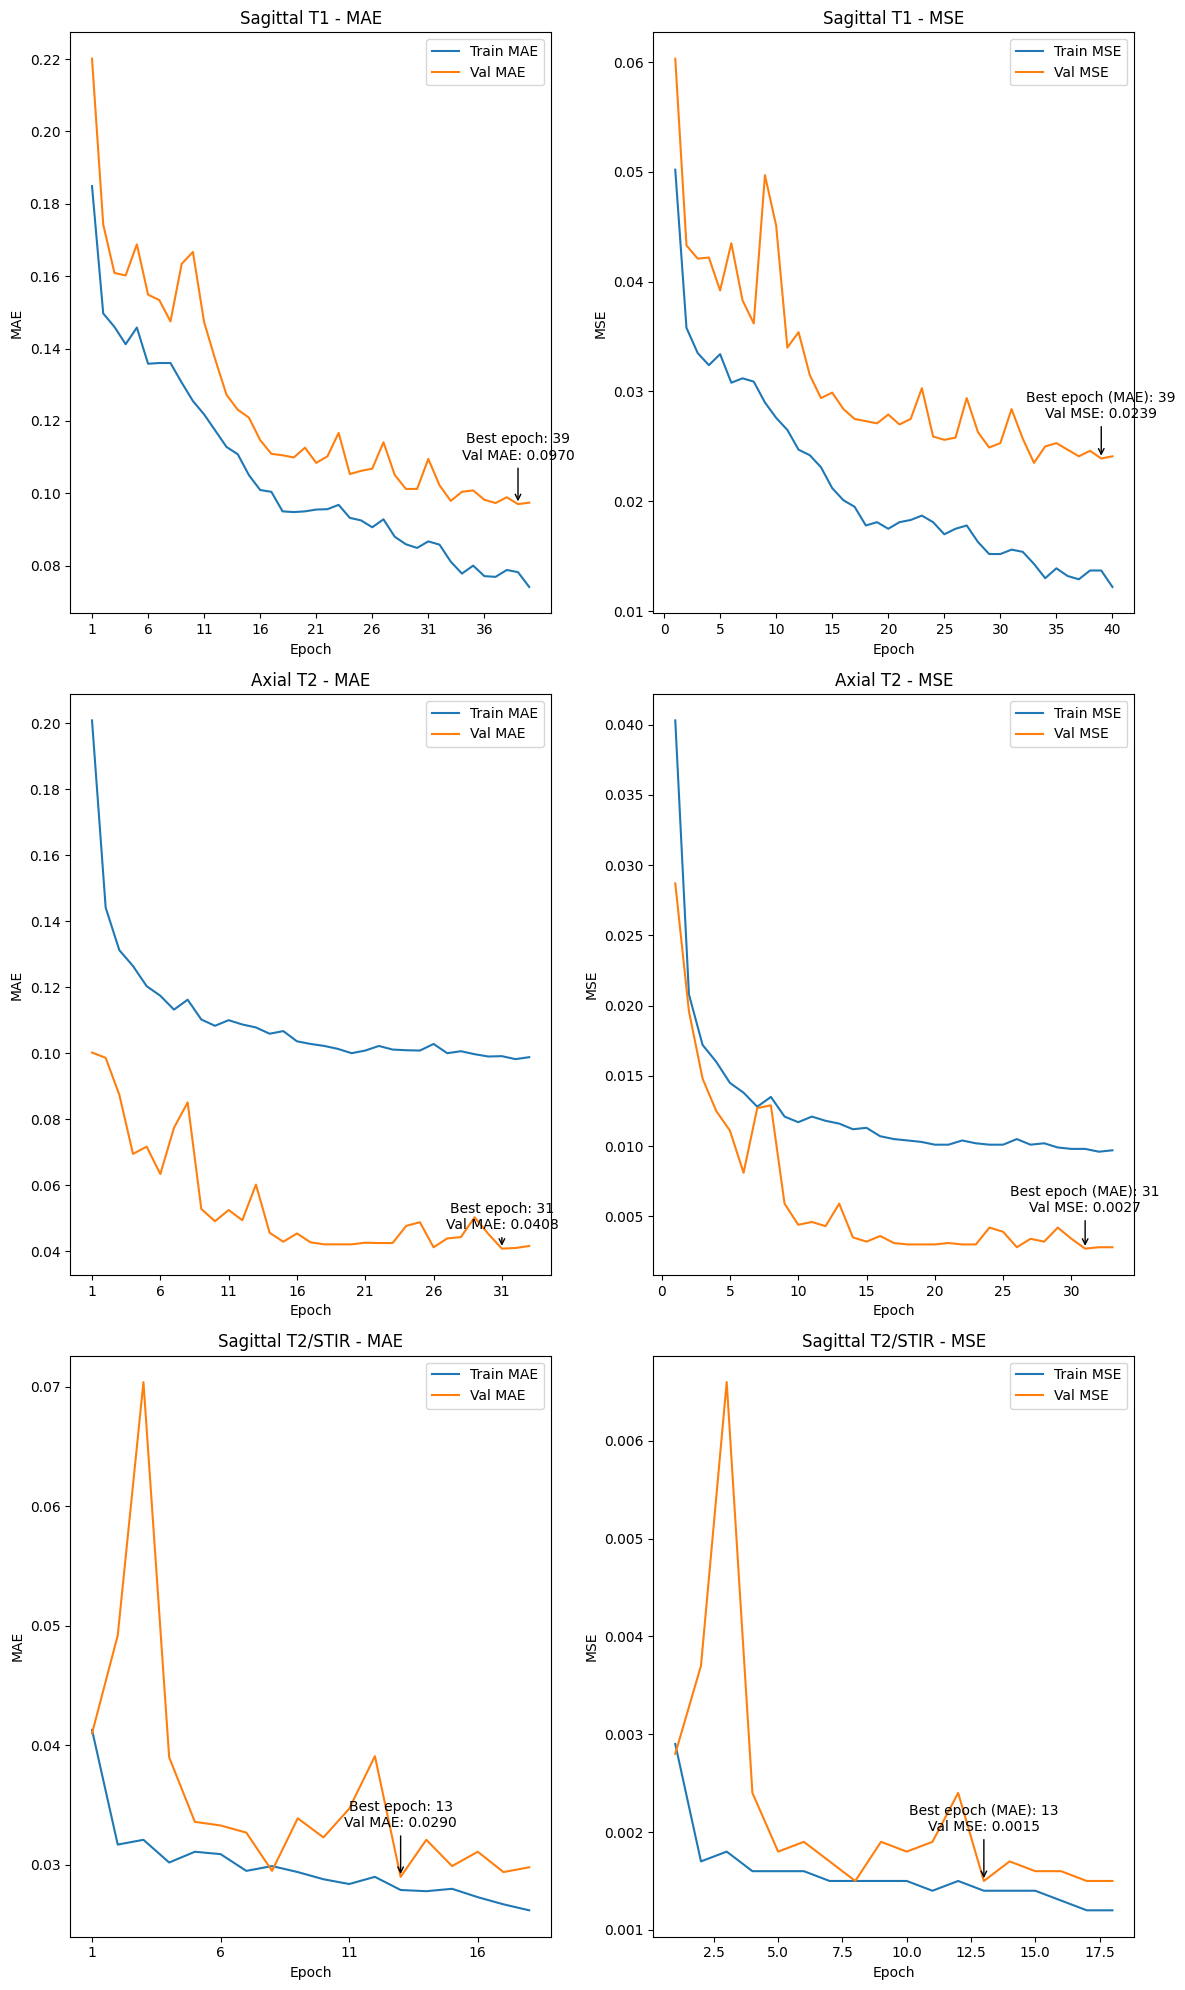

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# SAGITTAL T1 - 40 epochs
# -----------------------------
sagittal_t1_train_mae = [0.1849, 0.1497, 0.1460, 0.1412, 0.1458, 0.1358, 0.1360, 0.1360, 0.1306, 0.1255,
                         0.1218, 0.1173, 0.1128, 0.1108, 0.1050, 0.1009, 0.1004, 0.0950, 0.0948, 0.0950,
                         0.0955, 0.0956, 0.0968, 0.0932, 0.0925, 0.0906, 0.0928, 0.0880, 0.0859, 0.0849,
                         0.0867, 0.0858, 0.0811, 0.0778, 0.0800, 0.0771, 0.0769, 0.0788, 0.0782, 0.0741]

sagittal_t1_val_mae = [0.2201, 0.1743, 0.1609, 0.1602, 0.1688, 0.1549, 0.1534, 0.1475, 0.1634, 0.1667,
                       0.1473, 0.1369, 0.1272, 0.1231, 0.1209, 0.1147, 0.1109, 0.1105, 0.1099, 0.1126,
                       0.1084, 0.1102, 0.1167, 0.1053, 0.1062, 0.1068, 0.1141, 0.1051, 0.1012, 0.1012,
                       0.1095, 0.1022, 0.0979, 0.1004, 0.1008, 0.0982, 0.0973, 0.0989, 0.0970, 0.0974]

sagittal_t1_train_mse = [0.0502, 0.0358, 0.0335, 0.0324, 0.0334, 0.0308, 0.0312, 0.0309, 0.0290, 0.0276,
                         0.0265, 0.0247, 0.0242, 0.0231, 0.0212, 0.0201, 0.0195, 0.0178, 0.0181, 0.0175,
                         0.0181, 0.0183, 0.0187, 0.0181, 0.0170, 0.0175, 0.0178, 0.0163, 0.0152, 0.0152,
                         0.0156, 0.0154, 0.0143, 0.0130, 0.0139, 0.0132, 0.0129, 0.0137, 0.0137, 0.0122]

sagittal_t1_val_mse = [0.0603, 0.0433, 0.0421, 0.0422, 0.0392, 0.0435, 0.0383, 0.0362, 0.0497, 0.0451,
                       0.0340, 0.0354, 0.0315, 0.0294, 0.0299, 0.0284, 0.0275, 0.0273, 0.0271, 0.0279,
                       0.0270, 0.0275, 0.0303, 0.0259, 0.0256, 0.0258, 0.0294, 0.0263, 0.0249, 0.0253,
                       0.0284, 0.0257, 0.0235, 0.0250, 0.0253, 0.0247, 0.0241, 0.0246, 0.0239, 0.0241]

# -----------------------------
# AXIAL T2 - 33 epochs
# -----------------------------
axial_t2_train_mae = [0.2008, 0.1441, 0.1312, 0.1264, 0.1203, 0.1174, 0.1132, 0.1162, 0.1102, 0.1083,
                      0.1100, 0.1087, 0.1078, 0.1059, 0.1067, 0.1036, 0.1028, 0.1022, 0.1013, 0.1000,
                      0.1008, 0.1022, 0.1011, 0.1009, 0.1008, 0.1028, 0.1000, 0.1006, 0.0997, 0.0990,
                      0.0991, 0.0982, 0.0988]

axial_t2_val_mae = [0.1002, 0.0986, 0.0874, 0.0695, 0.0717, 0.0634, 0.0774, 0.0851, 0.0528, 0.0491,
                    0.0525, 0.0494, 0.0602, 0.0456, 0.0429, 0.0454, 0.0427, 0.0421, 0.0421, 0.0421,
                    0.0426, 0.0425, 0.0425, 0.0477, 0.0488, 0.0412, 0.0439, 0.0443, 0.0503, 0.0453,
                    0.0408, 0.0410, 0.0416]

axial_t2_train_mse = [0.0403, 0.0208, 0.0172, 0.0160, 0.0145, 0.0138, 0.0128, 0.0135, 0.0121, 0.0117,
                      0.0121, 0.0118, 0.0116, 0.0112, 0.0113, 0.0107, 0.0105, 0.0104, 0.0103, 0.0101,
                      0.0101, 0.0104, 0.0102, 0.0101, 0.0101, 0.0105, 0.0101, 0.0102, 0.0099, 0.0098,
                      0.0098, 0.0096, 0.0097]

axial_t2_val_mse = [0.0287, 0.0196, 0.0148, 0.0125, 0.0111, 0.0081, 0.0127, 0.0129, 0.0059, 0.0044,
                    0.0046, 0.0043, 0.0059, 0.0035, 0.0032, 0.0036, 0.0031, 0.0030, 0.0030, 0.0030,
                    0.0031, 0.0030, 0.0030, 0.0042, 0.0039, 0.0028, 0.0034, 0.0032, 0.0042, 0.0034,
                    0.0027, 0.0028, 0.0028]

# -----------------------------
# SAGITTAL T2/STIR - 18 epochs
# -----------------------------
t2stir_train_mae = [0.0413, 0.0317, 0.0321, 0.0302, 0.0311, 0.0309, 0.0295, 0.0299, 0.0294, 0.0288,
                    0.0284, 0.0290, 0.0279, 0.0278, 0.0280, 0.0273, 0.0267, 0.0262]

t2stir_val_mae = [0.0410, 0.0492, 0.0704, 0.0390, 0.0336, 0.0333, 0.0327, 0.0295, 0.0339, 0.0323,
                  0.0347, 0.0391, 0.0290, 0.0321, 0.0299, 0.0311, 0.0294, 0.0298]

t2stir_train_mse = [0.0029, 0.0017, 0.0018, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015,
                    0.0014, 0.0015, 0.0014, 0.0014, 0.0014, 0.0013, 0.0012, 0.0012]

t2stir_val_mse = [0.0028, 0.0037, 0.0066, 0.0024, 0.0018, 0.0019, 0.0017, 0.0015, 0.0019, 0.0018,
                  0.0019, 0.0024, 0.0015, 0.0017, 0.0016, 0.0016, 0.0015, 0.0015]

# Let me know when you're ready for me to paste the full plotting code using these updated arrays.


# ------------------------------------------------------------------------
# 2) UTILITY: Function to plot a single condition's (MAE, MSE) subplots
# ------------------------------------------------------------------------
def plot_regression(ax_mae, ax_mse,
                    train_mae, val_mae,
                    train_mse, val_mse,
                    title_str):
    """
    ax_mae, ax_mse : matplotlib Axes objects for the MAE and MSE subplots
    train_mae, val_mae, train_mse, val_mse : lists of metric values
    title_str : label/title for this condition's row
    """

    epochs = np.arange(1, len(train_mae) + 1)
    offset_mae = (max(val_mae) - min(val_mae)) * 0.1
    offset_mse = (max(val_mse) - min(val_mse)) * 0.1
    # ---- MAE subplot ----
    ax_mae.plot(epochs, train_mae, label='Train MAE')
    ax_mae.plot(epochs, val_mae, label='Val MAE')
    ax_mae.set_title(f'{title_str} - MAE')
    ax_mae.set_xlabel('Epoch')
    ax_mae.set_ylabel('MAE')
    ax_mae.set_xticks(np.arange(1, len(train_mae) + 1, 5))
    ax_mae.legend(loc='best')

    # Find best epoch (lowest val_mae)
    best_epoch_idx = np.argmin(val_mae)
    best_epoch_num = best_epoch_idx + 1
    best_val_mae = val_mae[best_epoch_idx]

    # Annotate on MAE subplot
    mae_text = f'Best epoch: {best_epoch_num}\nVal MAE: {best_val_mae:.4f}'
    ax_mae.annotate(
        mae_text,
        xy=(best_epoch_num, best_val_mae),
        xytext=(best_epoch_num, best_val_mae + offset_mae),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )

    # ---- MSE subplot ----
    ax_mse.plot(epochs, train_mse, label='Train MSE')
    ax_mse.plot(epochs, val_mse, label='Val MSE')
    ax_mse.set_title(f'{title_str} - MSE')
    ax_mse.set_xlabel('Epoch')
    ax_mse.set_ylabel('MSE')
    ax_mae.set_xticks(np.arange(1, len(train_mse) + 1, 5))
    ax_mse.legend(loc='best')

    # MSE at that same best epoch
    best_val_mse = val_mse[best_epoch_idx]
    mse_text = (f'Best epoch (MAE): {best_epoch_num}\n'
                f'Val MSE: {best_val_mse:.4f}')
    ax_mse.annotate(
        mse_text,
        xy=(best_epoch_num, best_val_mse),
        xytext=(best_epoch_num, best_val_mse + offset_mse),
        arrowprops=dict(arrowstyle='->', color='black'),
        ha='center'
    )


# ------------------------------------------------------------------------
# 3) MAIN PLOTTING (5 rows × 2 columns)
# ------------------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 20))

# Row 1: Left Neural Foraminal Narrowing
plot_regression(
    axes[0, 0],
    axes[0, 1],
    sagittal_t1_train_mae ,
    sagittal_t1_val_mae ,
    sagittal_t1_train_mse ,
    sagittal_t1_val_mse ,
    "Sagittal T1"
)

# Row 2: Right Neural Foraminal Narrowing
plot_regression(
    axes[1, 0],
    axes[1, 1],
    axial_t2_train_mae ,
    axial_t2_val_mae ,
    axial_t2_train_mse ,
    axial_t2_val_mse ,
    "Axial T2"
)

# Row 3: Left Subarticular Stenosis
plot_regression(
    axes[2, 0],
    axes[2, 1],
    t2stir_train_mae ,
    t2stir_val_mae ,
    t2stir_train_mse ,
    t2stir_val_mse ,
    "Sagittal T2/STIR"
)


plt.tight_layout()
plt.show()
